In [1]:

import matplotlib.pyplot as plt
import numpy as np
from metpy.interpolate import cross_section
from utility import load, util, analysis_parameters as ap
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import xarray as xr


MODEL = "FV3"
REGION = "TWP"
t = 71
lon0 = 151.85
lon1 = 151.35
lat0 = -1.75
lat1 = -2.5

In [ ]:

# %%
qi = load.load_frozen(MODEL, REGION)
# ql = load.load_liq(MODEL, REGION)
z = load.get_levels(MODEL, REGION)
olr, _ = load.get_olr_alb(MODEL, REGION)
fwp = load.get_iwp(MODEL, REGION, ice_only=False)[11::12]
qi = qi.rename({"time":"time","pfull":"isobaric","grid_xt":"lon","grid_yt":"lat"})
# ql = ql.rename({"time":"time","pfull":"isobaric","grid_xt":"lon","grid_yt":"lat"})
fwp = fwp.rename({"time":"time","grid_xt":"x","grid_yt":"y"})
qi

In [ ]:
ind = np.argmin(abs(qi.lat.values+2.1))
print(ind, qi.lat.values[ind])
fwp[t]

In [ ]:
np.sum(np.where(fwp>=1, 1, 0))/len(fwp.values.flatten())

In [ ]:
cats = np.where(fwp>=1, 1, 0)
cats = np.where((fwp<1)&(fwp>=1e-2), 2, cats)
cats = np.where((fwp<1e-1)&(fwp>=1e-4), 3, cats)
cats = np.where(fwp<1e-4, 4, cats)
fwp_x_width = fwp.x[1]-fwp.x[0]
colors = ['red','limegreen','C0','gray']
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]

In [ ]:
# qi = qi.where(qi>=1e-7, other=np.nan)
# ql = ql.where(ql>=1e-7, other=np.nan)

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(13,5))
cs_i = ax0.pcolormesh(qi.lon, z, np.log10(qi.values[t,:,ind,:]*1000), cmap="Blues",
                vmin=-6,vmax=1)
plt.colorbar(cs_i, ax=ax0, location="bottom", label="log10[qi (g/kg)]")
# cs_l = ax0.pcolormesh(ql.lon, z, np.log10(ql.values[t,:,ind,:]*1000), cmap="Reds",
#                 vmin=-6,vmax=1)
# plt.colorbar(cs_l, ax=ax0, location="bottom", label="log10[ql (g/kg)]")

ax0.set_ylim([-500,20000])
for i in range(fwp.x.shape[0]):
    cs_cats = ax0.fill([fwp.x[i]-fwp_x_width, fwp.x[i]-fwp_x_width, fwp.x[i]+fwp_x_width,fwp.x[i]+fwp_x_width], 
    [-500,500,500,-500], color=colors[cats[t,ind,i]-1])
ax0.legend(custom_lines, ['CAT 1', 'CAT 2', 'CAT 3', 'CIRRUS-FREE'], loc=9, bbox_to_anchor=(0.5,-0.1), ncol=4)
# plt.colorbar(cs_cats, ax=ax0, location="bottom", label="categories", ticks=[1,2,3,4])


cs_olr = ax1.pcolormesh(olr.grid_xt, olr.grid_yt, olr[t,:,:], cmap="viridis_r")
ax1.plot([143,153], [qi.lat.values[ind],qi.lat.values[ind]], 'r')
ax1.set_xlim([143,153])

plt.colorbar(cs_olr, ax=ax1, label="OLR (W/m2)")
fig.suptitle("Lat ="+str(qi.lat.values[ind])+" at time "+str(qi.time.values[t])+"UTC")
plt.savefig(f"../plots/fv3/cross_{t}_{ind}.jpg")
plt.show()


# use metpy cross section


In [49]:
qi = xr.open_dataset(ap.TWP_FV3_QI).metpy.parse_cf("qi")
fwp = xr.open_dataset(ap.TWP_FV3_IWP).metpy.parse_cf("intqi")
ind = np.argmin(abs(qi.grid_xt.values+2.1))
qi

Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable


<xarray.DataArray 'qi' (time: 320, pfull: 79, grid_yt: 342, grid_xt: 341)>
[2948204160 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2016-08-01T03:00:00 ... 2016-09-10
  * grid_xt    (grid_xt) float32 143.0 143.0 143.1 143.1 ... 152.9 152.9 153.0
  * grid_yt    (grid_yt) float32 -4.995 -4.966 -4.937 ... 4.937 4.966 4.995
  * pfull      (pfull) float32 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
    metpy_crs  object Projection: latitude_longitude
Attributes:
    long_name:      cloud ice mixing ratio
    units:          kg/kg
    cell_methods:   time: point
    interp_method:  conserve_order1

In [58]:
cross = cross_section(qi[t,:,:,:], (-1.75,151.85), (-2.5,151.35), steps=100, interp_type='linear')
cross_fwp = cross_section(fwp[t,:,:]*1000, (2.6,143), (2.7,153), steps=100, interp_type='linear')
# print(cross_fwp)

In [59]:
cats = np.where(cross_fwp>=1, 1, 0)
cats = np.where((cross_fwp<1)&(cross_fwp>=1e-2), 2, cats)
cats = np.where((cross_fwp<1e-1)&(cross_fwp>=1e-4), 3, cats)
cats = np.where(cross_fwp<1e-4, 4, cats)
colors = ['red','limegreen','C0','gray']
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
cats

array([0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3,
       3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0])

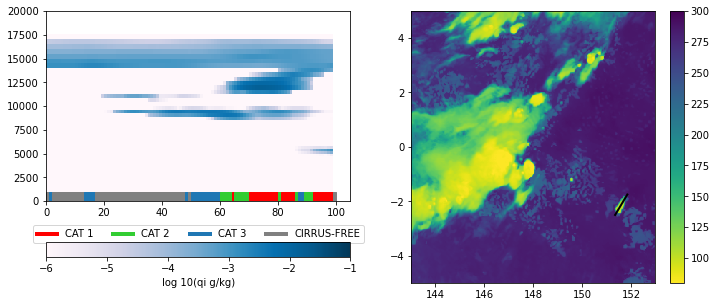

In [62]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(12,5))
pc0 = ax0.pcolormesh(cross.index, z, np.log10(cross*1000), cmap="PuBu", vmin=-6, vmax=-1)
ax0.set_ylim([0,20000])
plt.colorbar(pc0, location="bottom", label="log 10(qi g/kg)", ax=ax0)
for i in range(cross.index.shape[0]):
    cs_cats = ax0.fill([i,i,i+1,i+1], 
    [0,1000,1000,0], color=colors[cats[i]-1])
ax0.legend(custom_lines, ['CAT 1', 'CAT 2', 'CAT 3', 'CIRRUS-FREE'], loc=9, bbox_to_anchor=(0.5,-0.1), ncol=4)

pc1 = ax1.pcolormesh(olr.grid_xt, olr.grid_yt, olr[t], cmap="viridis_r", vmin=80, vmax=300)
plt.colorbar(pc1)
ax1.plot([lon0,lon1], [lat0,lat1], linewidth=2, color='k')
plt.show()